In [509]:
#imported various necessary libraries for data analysis and visualization导入需要用到的库和工具
import pandas as pd
import re
import numpy as np
import nltk
import spacy
import os
import random
import matplotlib.pyplot as plt
import ast
import logging
import seaborn as sns
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from collections import defaultdict
from sklearn.datasets import make_classification
from scipy.cluster import hierarchy
from scipy.spatial import distance
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [510]:
# set up logging for code processing 设置日志目录
logging.basicConfig(filename='code_processing.log', level=logging.INFO, format='%(asctime)s:%(levelname)s:%(message)s')

class FunctionVisitor(ast.NodeVisitor):
    def __init__(self):
        self.recursive = defaultdict(bool)

    def visit_FunctionDef(self, node):
        for n in ast.walk(node):
            if isinstance(n, ast.Call):
                if isinstance(n.func, ast.Name):
                    if n.func.id == node.name:
                        self.recursive[node.name] = True

        self.generic_visit(node)

In [511]:

# Root directory path   定义根目录
root_dir_path = 'E:\TERM2\Dissertation\Dataset\Project_CodeNet\Project_CodeNet\data'

# Initialize a list to store all Python file paths 初始化一个列表来储存Python文件路径
all_python_files = []

# Iterate through each project in the root directory  遍历根目录下的每个项目
for project in os.listdir(root_dir_path):
    project_path = os.path.join(root_dir_path, project)
    
    # Check if the project has a "Python" folder 检查每个项目是否报含一个Python文件夹
    python_folder_path = os.path.join(project_path, 'Python')
    if os.path.exists(python_folder_path):
        
        # Extract all .py files from the Python folder   从Python文件夹里提取所有后缀为 .py的文件
        python_files = [os.path.join(python_folder_path, file) 
                        for file in os.listdir(python_folder_path) 
                        if file.endswith('.py')]
        
        all_python_files.extend(python_files)

In [512]:
number_of_python_files = len(all_python_files)
print(number_of_python_files)


600540


In [513]:


# Number of files to analyze 文件数量设为50000
num_files_to_analyze = 50000

# Number of files in each batch 每批次的文件数量设为5000
batch_size = 5000

# Total number of batches 批次总数
num_batches = num_files_to_analyze // batch_size

# Randomly sample 50,000 files from all_python_files for analysis
sampled_files_total = random.sample(all_python_files, num_files_to_analyze)

# Output directory for processed batches  处理批次的输出目录
output_dir = "E:\TERM2\Dissertation\Dataset\Project_CodeNet\Project_CodeNet\Output"

# Create an empty data frame to store all the 50000 files
df_total = pd.DataFrame(columns=['file_name', 'num_lines','num_for_loops',
        'num_while_loops',
        'num_functions',
        'num_classes',
        'num_imports',
        'num_nesting_depth',
        'num_nested_loops',
        'code_content',
                                ])

# Process and save each batch 处理并储存每个批次
for batch_num in range(num_batches):

    # Starting and ending index for each batch  每批的开始和结束索引
    start_idx = batch_num * batch_size
    end_idx = (batch_num + 1) * batch_size
    
    # Selecting files for the current batch 当前批次的文件
    current_batch_files = sampled_files_total[start_idx:end_idx]

    print(f"Processing {len(current_batch_files)} Python files for batch {batch_num + 1}.")
    
    # Initialize lists to store features and code samples 初始化列表来储存特征和代码样本
    num_lines, num_for_loops, num_while_loops, num_functions, num_classes, num_imports = [], [], [], [], [], []
    num_nesting_depth, num_nested_loops, code_samples = [], [], []
    
    # Extract features from each file in current_batch_files 从每个样本文件中提取特征
    for file_path in current_batch_files:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            content = file.read()
            code_samples.append(content)
        
            # Basic features 提取的基础特征如下
            num_lines.append(len(content.split("\n")))
            num_for_loops.append(len(re.findall(r'\bfor\b', content)))
            num_while_loops.append(len(re.findall(r'\bwhile\b', content)))
            num_functions.append(len(re.findall(r'\bdef\b', content)))
            num_classes.append(len(re.findall(r'\bclass\b', content)))
            num_imports.append(len(re.findall(r'\bimport\b', content)))
            num_nesting_depth.append(max([line.count("\t") + line.count("    ") for line in content.split("\n")]))
            nested_loops = sum(1 for line in content.split("\n") if (line.strip().startswith(('for ', 'while ')) and line.count("\t") > 1 or line.count("    ") > 4))
            num_nested_loops.append(nested_loops)
            
    # Create a DataFrame for extracted features 为提取的每个特征创建一个数据框
    df = pd.DataFrame({
        'file_name': [os.path.basename(f) for f in current_batch_files],
        'num_lines': num_lines,
        'num_for_loops': num_for_loops,
        'num_while_loops': num_while_loops,
        'num_functions': num_functions,
        'num_classes': num_classes,
        'num_imports': num_imports,
        'num_nesting_depth': num_nesting_depth,
        'num_nested_loops': num_nested_loops,
        'code_content': code_samples,
    })
    df_total = pd.concat((df, df_total),axis=0)

    # Save the current batch DataFrame to CSV 将当前批次的dataframe储存为CSV表格文件
    csv_name = os.path.join(output_dir, f"batch_{batch_num + 1}.csv")
    df.to_csv(csv_name, index=False)


Processing 5000 Python files for batch 1.
Processing 5000 Python files for batch 2.
Processing 5000 Python files for batch 3.
Processing 5000 Python files for batch 4.
Processing 5000 Python files for batch 5.
Processing 5000 Python files for batch 6.
Processing 5000 Python files for batch 7.
Processing 5000 Python files for batch 8.
Processing 5000 Python files for batch 9.
Processing 5000 Python files for batch 10.


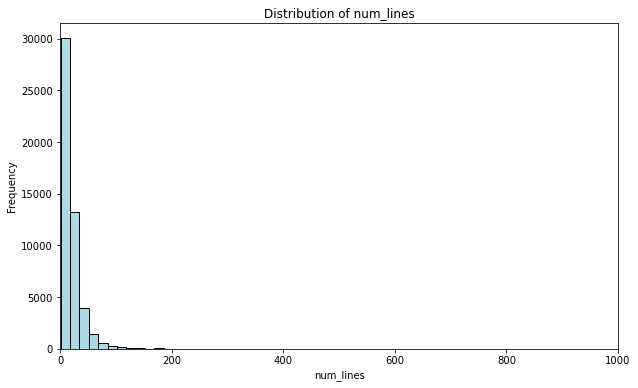

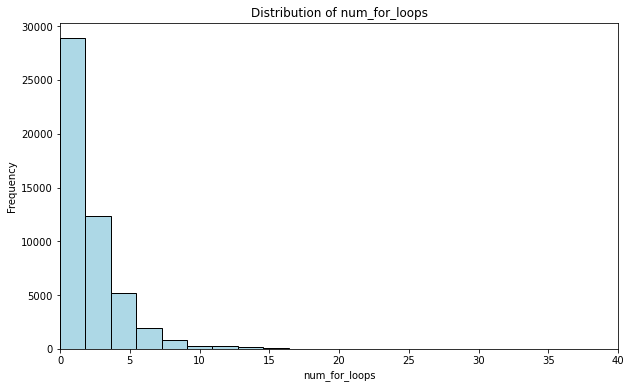

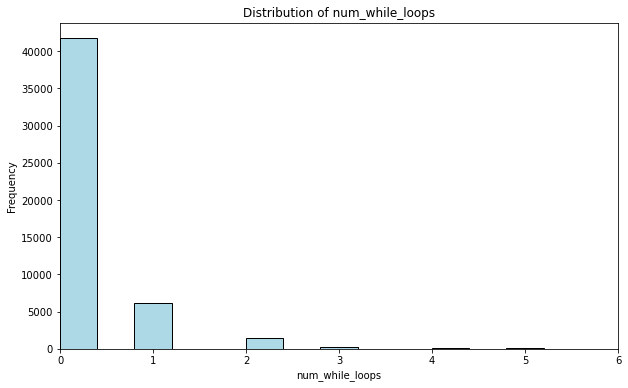

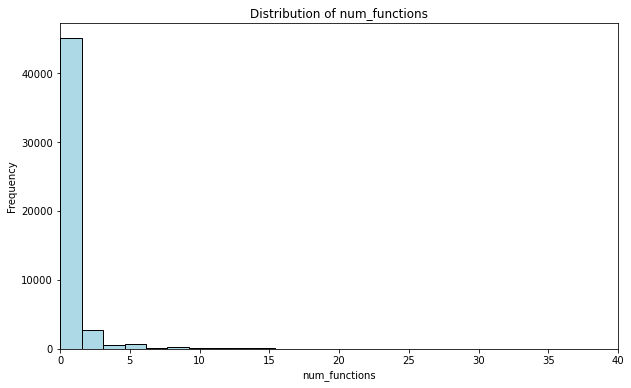

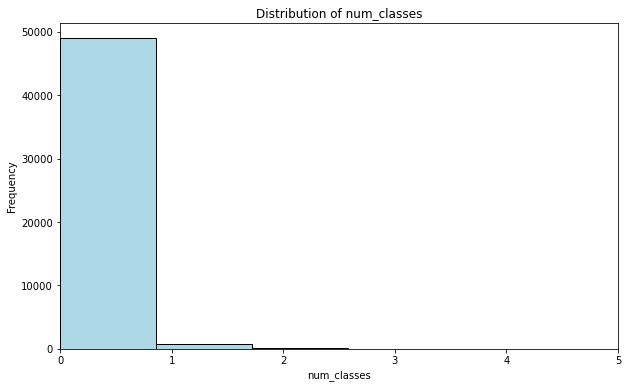

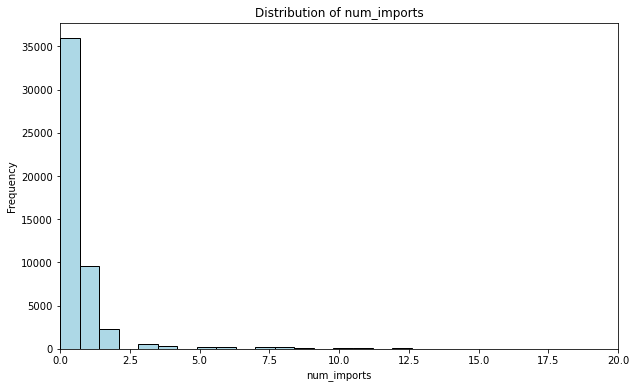

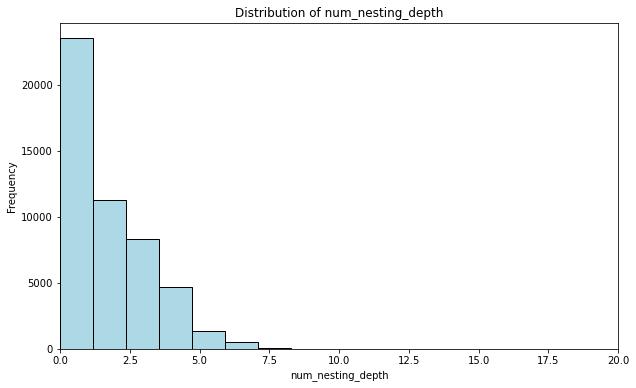

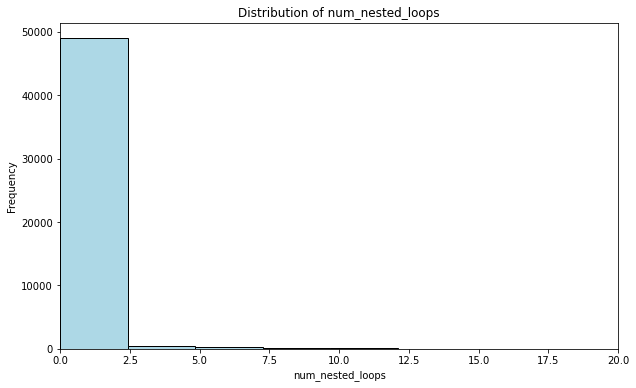

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   file_name          50000 non-null  object
 1   num_lines          50000 non-null  object
 2   num_for_loops      50000 non-null  object
 3   num_while_loops    50000 non-null  object
 4   num_functions      50000 non-null  object
 5   num_classes        50000 non-null  object
 6   num_imports        50000 non-null  object
 7   num_nesting_depth  50000 non-null  object
 8   num_nested_loops   50000 non-null  object
 9   code_content       50000 non-null  object
dtypes: object(10)
memory usage: 4.2+ MB
None
            file_name  num_lines  num_for_loops  num_while_loops  \
count           50000      50000          50000            50000   
unique          50000        256             43               16   
top     s220943823.py          6              0                0   
freq      

In [514]:

# If the 'num_nested_loops' column is missing, log a warning message. 如果缺少number of nested loops， 要记录警告信息
if 'num_nested_loops' not in df.columns:
    logging.warning("'num_nested_loops' column missing from the df DataFrame. Please check the feature extraction process.")

# Plot histograms for the features 为特征创建直方图
features_to_plot = ['num_lines', 'num_for_loops', 'num_while_loops', 'num_functions', 'num_classes', 'num_imports', 'num_nesting_depth', 'num_nested_loops']
xlim_list = [[0,1000], [0, 40], [0,6], [0,40], [0, 5], [0,20], [0,20], [0, 20]]
for i in range(len(features_to_plot)):
    feature = features_to_plot[i]
    lim = xlim_list[i]
    if feature in df_total.columns:
        plt.figure(figsize=(10, 6))
        plt.xlim(lim)
        df_total[feature].plot(kind='hist', bins=50, color='lightblue', edgecolor='black')
        plt.title(f'Distribution of {feature}')
        plt.xlabel(feature)
        plt.show()
    else:
        logging.warning(f"{feature} column not found in the df DataFrame.")
        
        



# Inspecting the Data 检查数据
print(df_total.info())
print(df_total.describe())

In [515]:
df_total.head

<bound method NDFrame.head of           file_name num_lines num_for_loops num_while_loops num_functions  \
0     s220943823.py         6             1               0             0   
1     s955736878.py        31             2               0             1   
2     s482935140.py        26             2               0             0   
3     s939308943.py        45             6               0             0   
4     s310726724.py        12             1               0             0   
...             ...       ...           ...             ...           ...   
4995  s122760724.py         5             0               0             0   
4996  s928712786.py        45             5               0             0   
4997  s830274030.py        11             3               0             0   
4998  s352406611.py        23             1               0             0   
4999  s691665444.py        19             1               0             1   

     num_classes num_imports num_nesting_dept

In [516]:
df_total.columns

Index(['file_name', 'num_lines', 'num_for_loops', 'num_while_loops',
       'num_functions', 'num_classes', 'num_imports', 'num_nesting_depth',
       'num_nested_loops', 'code_content'],
      dtype='object')

In [517]:
    
# Handling Outliers using IQR method  使用IQR处理异常值
cols_to_check = ['num_lines', 'num_for_loops', 'num_while_loops', 'num_functions', 'num_classes', 'num_imports', 'num_nesting_depth', 'num_nested_loops']
for col in cols_to_check:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Replace outliers with boundary values  用边值替代异常值
    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
     

# Advanced Tokenization using NLTK and SpaCy   用NLTK 和 Spacy进行高级标记化
nlp = spacy.load("en_core_web_sm")  # Make sure you've downloaded this model using 'python -m spacy download en_core_web_sm'
def advanced_tokenize(text):
    # Using NLTK's word_tokenize method 用NLTK的word_tokenize方法
    tokens = nltk.word_tokenize(text)
    
    # Further tokenization and processing using SpaCy  使用Spacy来进一步标记化和处理
    doc = nlp(' '.join(tokens))
    tokens = [token.text for token in doc]
    
    return tokens

print(df.columns)

Index(['file_name', 'num_lines', 'num_for_loops', 'num_while_loops',
       'num_functions', 'num_classes', 'num_imports', 'num_nesting_depth',
       'num_nested_loops', 'code_content'],
      dtype='object')


In [518]:
#Preprocessing Step 4 Label Assignment 标签分配 
def assign_label(row):
    features = ['num_lines', 'num_for_loops', 'num_while_loops', 'num_functions', 'num_classes', 'num_imports', 'num_nesting_depth', 'num_nested_loops']

# Calculate scores for each feature 为每个标签计算分数
    score = 0
    for feature in features:
        low_threshold = df[feature].quantile(0.20)
        high_threshold = df[feature].quantile(0.80)
    
        if row[feature] < low_threshold:
            score -= 1
        elif row[feature] > high_threshold:
            score += 1

    # Assign labels based on the total score  根据总分分配标签
    if score > 0:
        return 'High'
    elif score < 0:
        return 'Low'
    else:
        return 'Medium'
    
df_total['complexity'] = df_total.apply(assign_label, axis=1)

print(df_total['complexity'].value_counts())

High      22286
Medium    18184
Low        9530
Name: complexity, dtype: int64


In [519]:
print(df_total.columns)


Index(['file_name', 'num_lines', 'num_for_loops', 'num_while_loops',
       'num_functions', 'num_classes', 'num_imports', 'num_nesting_depth',
       'num_nested_loops', 'code_content', 'complexity'],
      dtype='object')


In [520]:

from sklearn.model_selection import train_test_split

# First, split the data into a training set (70%) and a temporary set (30%) using stratified sampling.
train_df, temp_df = train_test_split(df_total, test_size=0.3, stratify=df_total['complexity'], random_state=42)

# Next, split the temporary set into a test set (67%) and a validation set (33%) using stratified sampling.
test_df, val_df = train_test_split(temp_df, test_size=0.67, stratify=temp_df['complexity'], random_state=42)

# Display the shapes of the training, testing, and validation sets
print("Training Set Shape:", train_df.shape)
print("Testing Set Shape:", test_df.shape)
print("Validation Set Shape:", val_df.shape)



Training Set Shape: (35000, 11)
Testing Set Shape: (4950, 11)
Validation Set Shape: (10050, 11)


High      22286
Medium    18184
Low        9530
Name: complexity, dtype: int64
High      44.572
Medium    36.368
Low       19.060
Name: complexity, dtype: float64


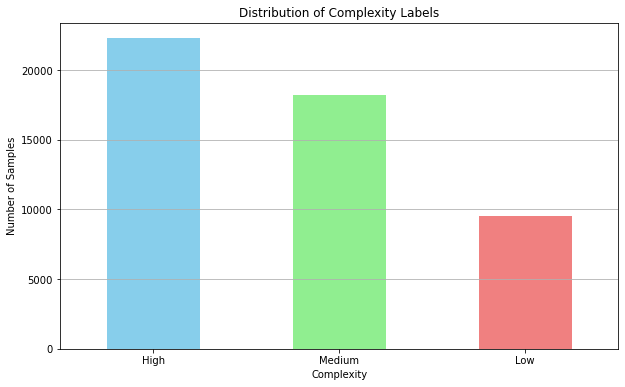

In [521]:
#Exploratory Data Analysis (EDA) - displayed the distribution of the 'complexity' labels 探索性数据分析之“复杂性”标签的分布

# check the distribution of the 'complexity' labels 检查复杂性标签的分布
print(df_total['complexity'].value_counts())
# print the percentage distribution of each complexity label in the dataset 打印数据集每个复杂性标签的分布
print(df_total['complexity'].value_counts(normalize=True) * 100)


 
df_sample = df_total.sample(frac=0.1, random_state=42)
# Distribution of Complexity Labels使用条形图来可视化复杂性标签的分布
complexity_counts = df_total['complexity'].value_counts()



plt.figure(figsize=(10, 6))
complexity_counts.plot(kind='bar', color=['skyblue', 'lightgreen', 'lightcoral'])
plt.title('Distribution of Complexity Labels')
plt.xlabel('Complexity')
plt.ylabel('Number of Samples')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()


In [522]:
df_total["complexity"].head

<bound method NDFrame.head of 0          Low
1         High
2       Medium
3         High
4       Medium
         ...  
4995       Low
4996      High
4997    Medium
4998    Medium
4999      High
Name: complexity, Length: 50000, dtype: object>

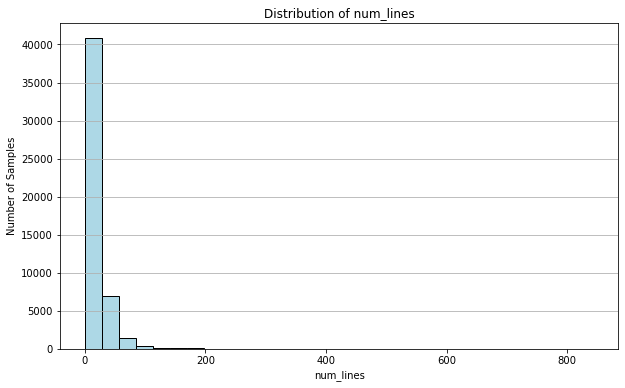

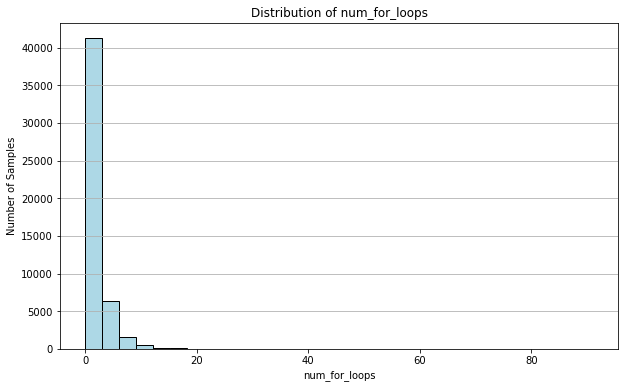

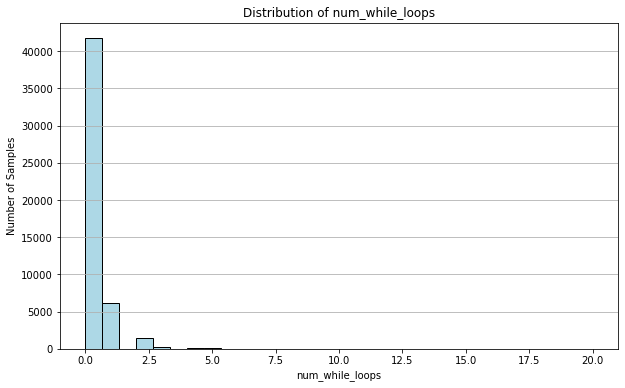

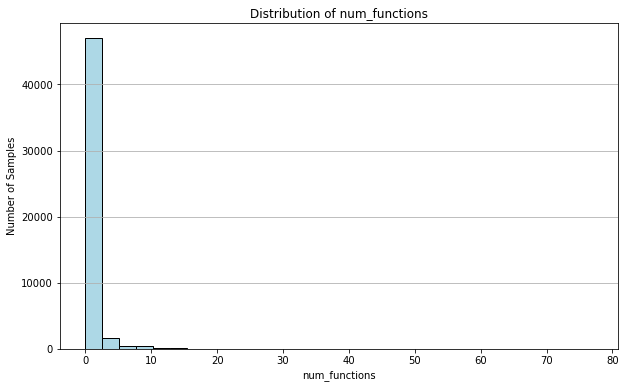

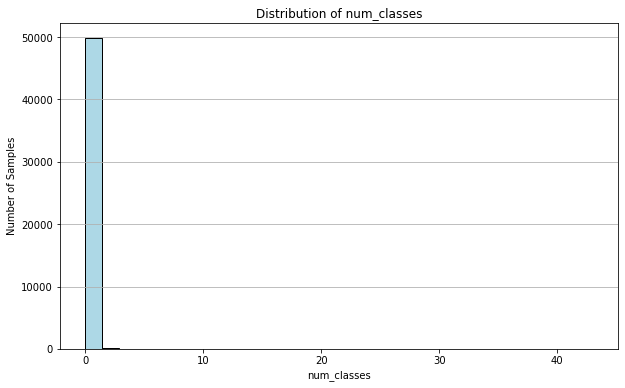

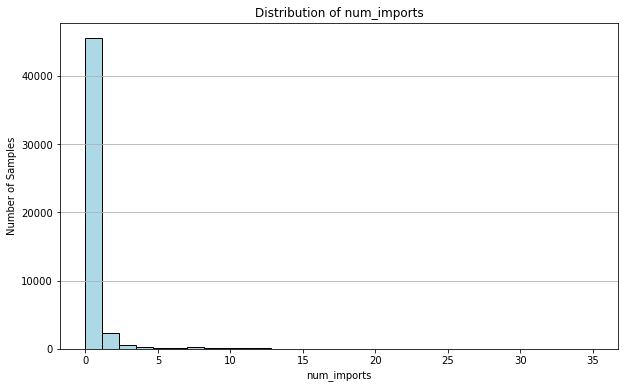

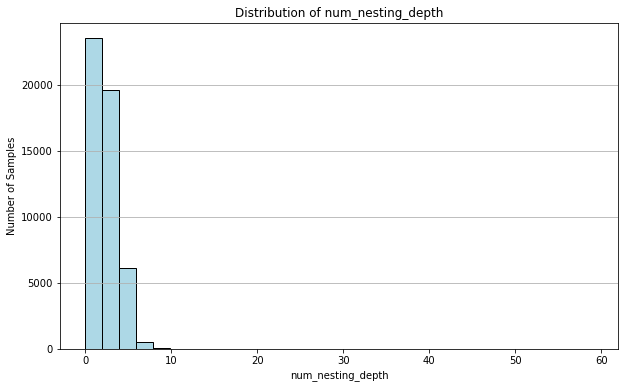

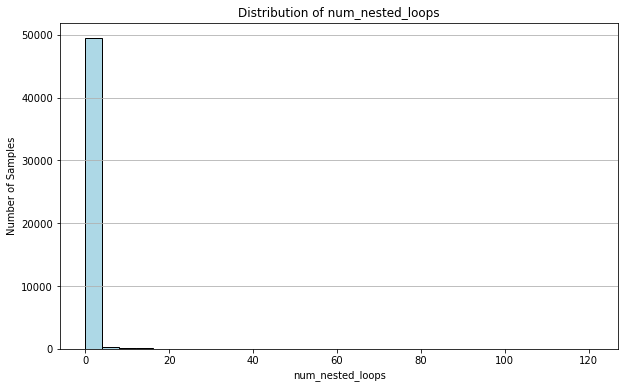

In [523]:
# df_total['complexity'] = df_total.apply(assign_label, axis=1)
#单变量分析Univariate Analysis 可视化每个特征的分布Visualize the distribution of each feature

for feature in df_total.columns[1:9]:  # Skipping the 'file_name' column
#     if np.issubdtype(df_total[feature].dtype, np.number):  # Check if the column is numeric
    plt.figure(figsize=(10, 6))
    df_total[feature].plot(kind='hist', bins=30, color='lightblue', edgecolor='black')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Number of Samples')
    plt.grid(axis='y')
    plt.show()


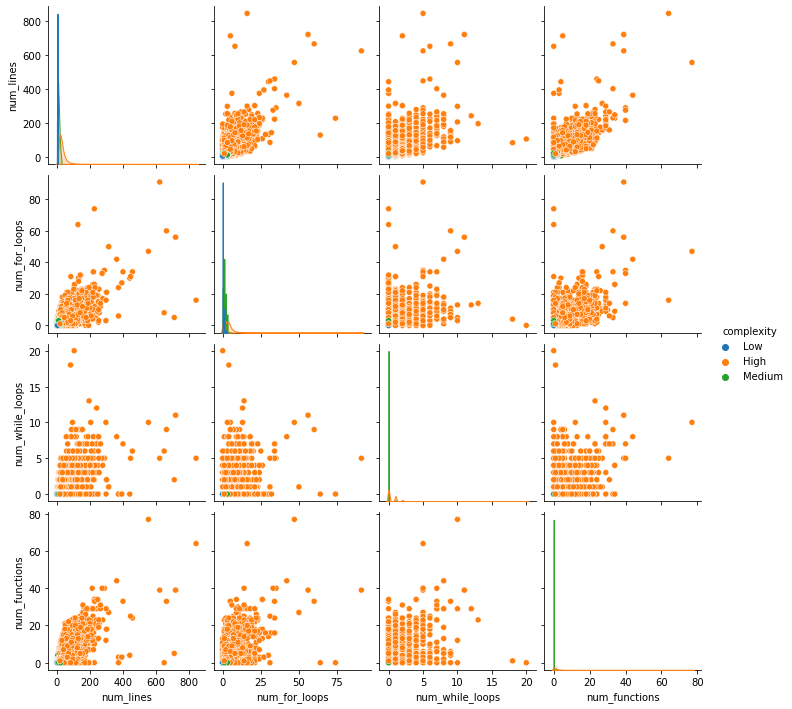

In [524]:
# # 多变量分析Multivariate Analysis散点图，检查数字特征之间的关系 Using pairplot from seaborn can be resource-intensive for many features; instead, let's pick a subset

df_total = df_total.reset_index(drop=True)
selected_features = ['num_lines', 'num_for_loops', 'num_while_loops', 'num_functions', 'complexity']
sns.pairplot(df_total[selected_features], hue='complexity')
plt.show()


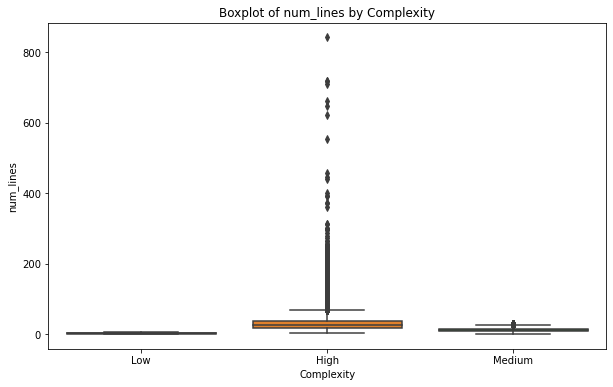

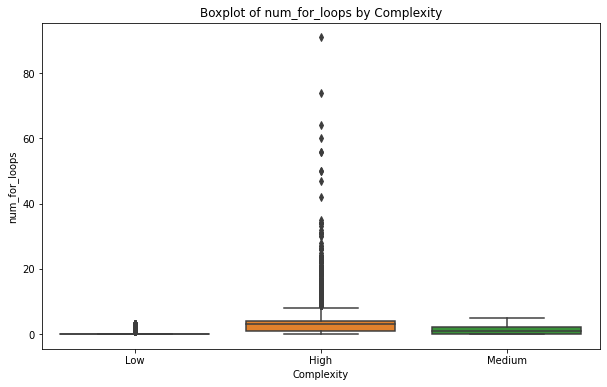

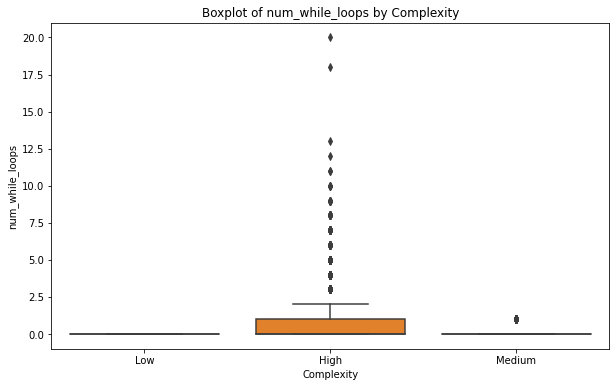

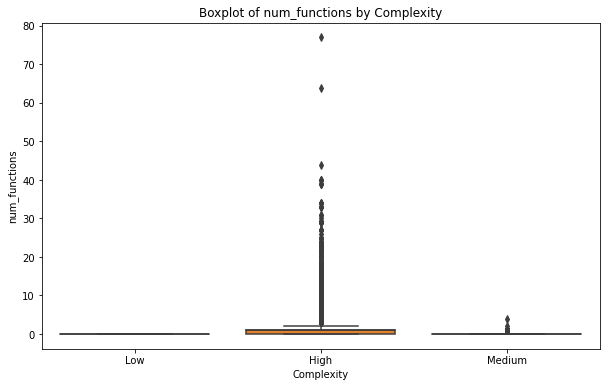

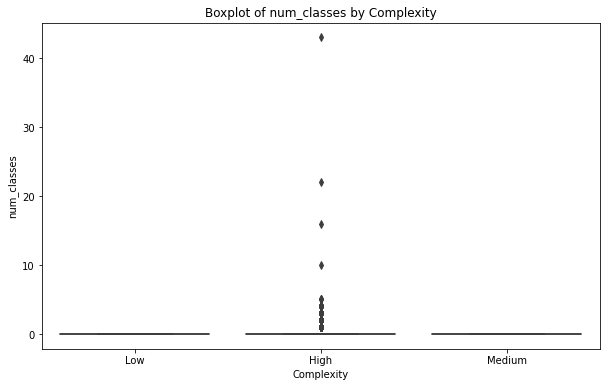

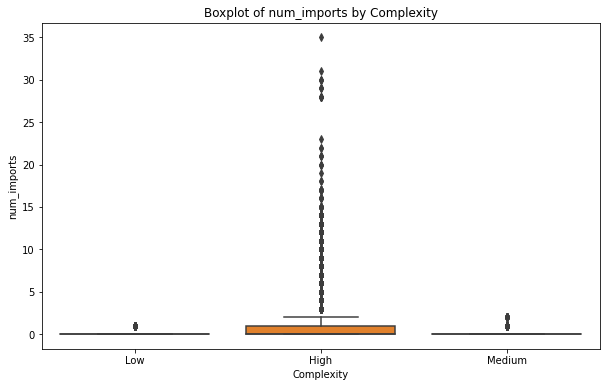

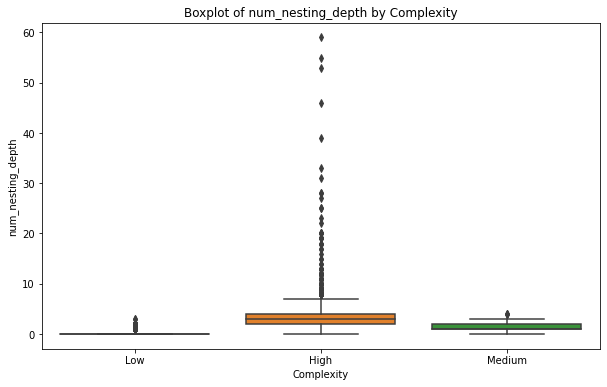

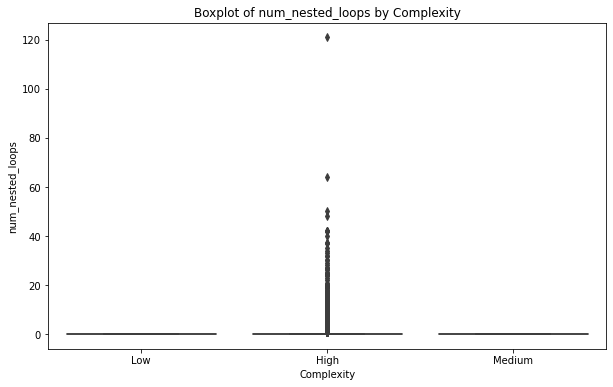

In [525]:
#Multivariate Analysis多变量分析之箱线图，对于分类（复杂性）与数字特征
#For categorical vs. numerical features, use boxplots
numeric_columns = df.select_dtypes(include=['number']).columns

for feature in numeric_columns:
    if (feature != 'file_name') and (feature != 'code_content'):  # Ensure we skip the 'file_name' column
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='complexity', y=feature, data=df_total)
        plt.title(f'Boxplot of {feature} by Complexity')
        plt.xlabel('Complexity')
        plt.show()

(50000, 4)
                 num_lines  num_for_loops  num_while_loops  num_functions
num_lines         1.000000       0.704992         0.500935       0.704813
num_for_loops     0.704992       1.000000         0.258088       0.487295
num_while_loops   0.500935       0.258088         1.000000       0.347200
num_functions     0.704813       0.487295         0.347200       1.000000


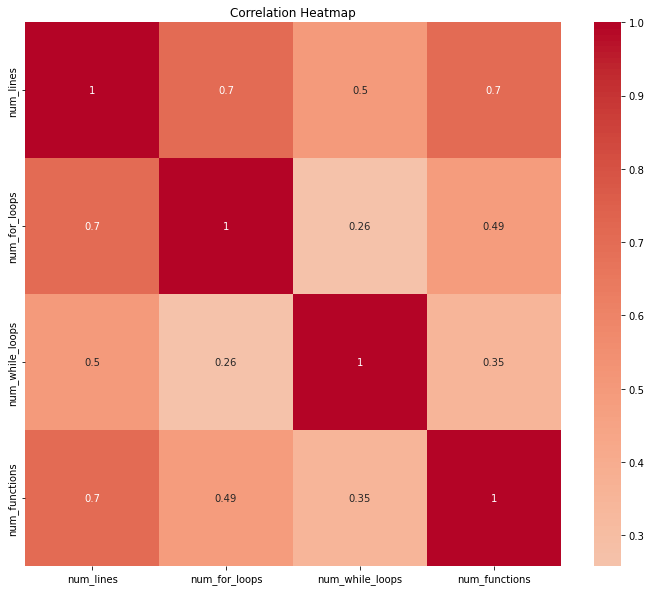

In [526]:
# Calculate correlation matrix  计算相关矩阵
df_cleaned = df_total.dropna()
selected_features = ['num_lines', 'num_for_loops', 'num_while_loops', 'num_functions']
corr = df_cleaned[selected_features].astype(float).corr()

print(df_cleaned[selected_features].shape)
print(corr)

# Plot heatmap  相关性可视化的热图
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title('Correlation Heatmap')
plt.show()

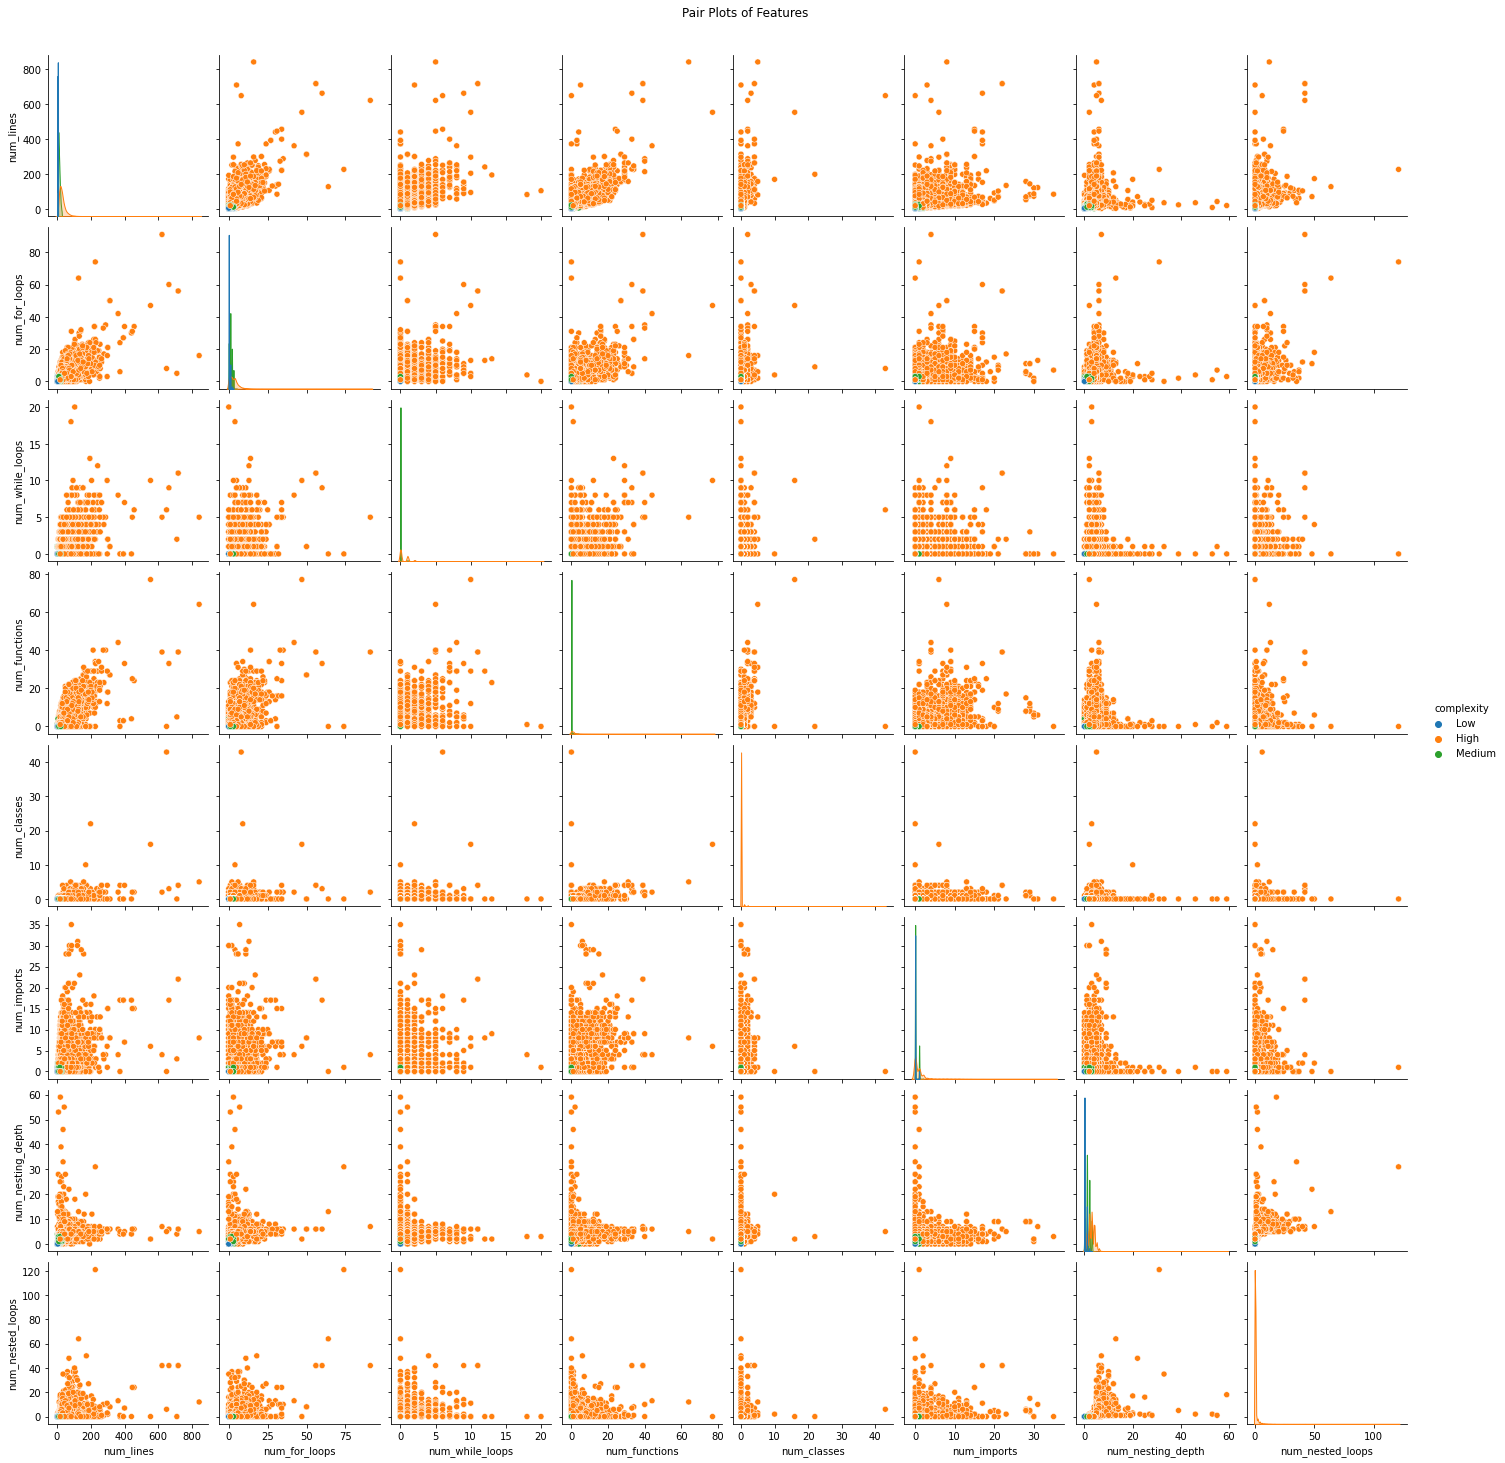

In [527]:
#Pair Plots配对图
sns.pairplot(df_total, hue='complexity')
plt.suptitle('Pair Plots of Features', y=1.02)
plt.show()

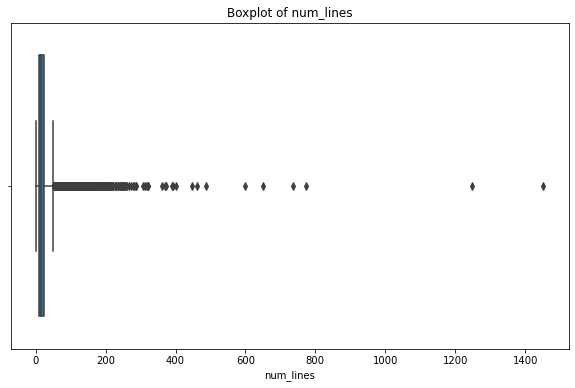

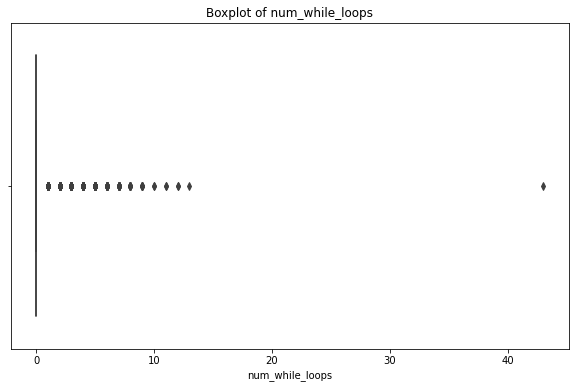

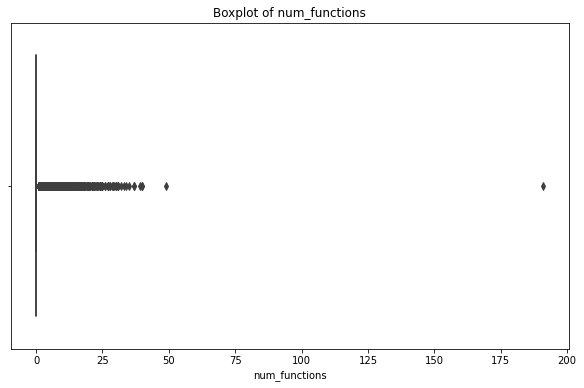

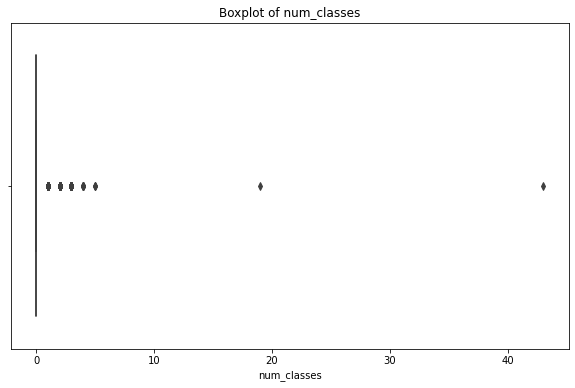

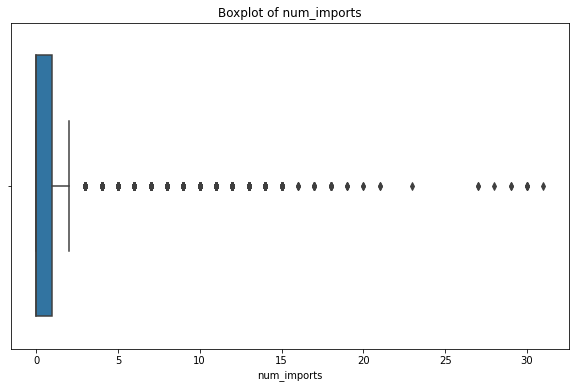

In [502]:
#Anomaly Detection using Boxplots  使用箱线图进行异常值检测

# for feature in numeric_features:
#     plt.figure(figsize=(10, 6))
#     sns.boxplot(x=df_total[feature])
#     plt.title(f'Boxplot of {feature}')
#     plt.show()

# df_total.to_csv('sampled_features.csv', index=False)

In [528]:
print(df_total.head())
print(df_total.columns)

       file_name num_lines num_for_loops num_while_loops num_functions  \
0  s220943823.py         6             1               0             0   
1  s955736878.py        31             2               0             1   
2  s482935140.py        26             2               0             0   
3  s939308943.py        45             6               0             0   
4  s310726724.py        12             1               0             0   

  num_classes num_imports num_nesting_depth num_nested_loops  \
0           0           0                 2                0   
1           0           2                 2                0   
2           0           1                 2                0   
3           0           0                 3                0   
4           0           0                 2                0   

                                        code_content complexity  
0  X = int(input())\n\nfor x in range(X, 0, -1):\...        Low  
1  import sys\nsys.setrecursionlimit(1

In [529]:
#Preprocessing Step 5 Text Preprocessing 文本预处理 (NLTK and SpaCy)
import spacy
import nltk
from nltk.corpus import stopwords

# Ensure the necessary resources are available
nltk.download('punkt')
nltk.download('stopwords')

nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# Define a function to tokenize Python code and remove stopwords
def advanced_tokenize(code_content):
    # Initialize an empty list to hold the tokens
    tokens = []
    
    # Tokenize the code content using SpaCy
    doc = nlp(code_content)
    for token in doc:
        # Check if the token is not a stop word, not a punctuation, not a space, and not a number
        if not token.is_stop and not token.is_punct and not token.is_space and not token.like_num:
            # Append the token to the list of tokens
            tokens.append(token.text)
            
    return tokens


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\t'y'y\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\t'y'y\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [530]:

import logging
from nltk.corpus import stopwords

# Define Python-specific stopwords 定义Python特定的停用词
python_stopwords = ["import", "from", "as", "def", "return", "for", "while", "if", "elif", "else", "in", "print", "with", "break", "continue", "pass", "class"]
all_stopwords = set(stopwords.words('english') + python_stopwords)


column_name = 'code_content'  # Replace with the actual column name containing the code in  DataFrame

if column_name in df_total.columns:
    # Create a new DataFrame df_code from df_total
    df_code = df_total[[column_name]].copy()
    
    # Apply the advanced_tokenize function to the 'code_content' column
    df_total['advanced_tokenized_code'] = df_code[column_name].apply(advanced_tokenize)
#     df_total['advanced_tokenized_code'] = python_stopwords.apply(advanced_tokenize)######新加的
else:
    logging.error(f"{column_name} column not found in the df_total DataFrame.")


AttributeError: 'list' object has no attribute 'apply'

In [532]:
df_total['advanced_tokenized_code'][0
                                ]

['X',
 '=',
 'int(input',
 'x',
 'range(X',
 'x',
 '0.5).is_integer',
 'print(x',
 'exit']

In [507]:
df_total.head().T

0              1              2              3  \
file_name          s062040851.py  s092888225.py  s491243685.py  s673445631.py   
num_lines                     12             12             17             15   
num_for_loops                  1              2              0              0   
num_while_loops                0              0              0              0   
num_functions                  0              0              0              0   
num_classes                    0              0              0              0   
num_imports                    0              0              1              0   
num_nesting_depth              2              2              1              0   
num_nested_loops               0              0              0              0   
complexity                Medium         Medium         Medium         Medium   

                               4  
file_name          s002459747.py  
num_lines                     27  
num_for_loops                  6  
num_while_loops                0  
num_functions                  0  
num_classes                    0  
num_imports                    0  
num_nesting_depth              4  
num_nested_loops               0  
complexity                  High

In [533]:
# Simple tokenization using string methods
def simple_tokenize(text):
    return text.lower().split()

# Tagging the data using simple tokenization
tagged_data = [TaggedDocument(words=simple_tokenize(_d), tags=[str(i)]) for i, _d in enumerate(df_total['code_content'])]
#advanced_tokenize(code_content)
# Training the Doc2Vec model
model = Doc2Vec(vector_size=20, window=2, min_count=1, workers=4, epochs=100)
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

# Transforming code snippets into vectors
df_total['doc2vec_vector'] = df_total['code_content'].apply(lambda x: model.infer_vector(simple_tokenize(x)))

df_total.head()



file_name num_lines num_for_loops num_while_loops num_functions  \
0  s220943823.py         6             1               0             0   
1  s955736878.py        31             2               0             1   
2  s482935140.py        26             2               0             0   
3  s939308943.py        45             6               0             0   
4  s310726724.py        12             1               0             0   

  num_classes num_imports num_nesting_depth num_nested_loops  \
0           0           0                 2                0   
1           0           2                 2                0   
2           0           1                 2                0   
3           0           0                 3                0   
4           0           0                 2                0   

                                        code_content complexity  \
0  X = int(input())\n\nfor x in range(X, 0, -1):\...        Low   
1  import sys\nsys.setrecursionlimit(10 ** 7)\nin...       High   
2  import math\n\n# one = 1000000000000001\ndict=...     Medium   
3  mod = 10**9+7\nN = int(input())\nA = list(map(...       High   
4  s = input()\ncnt = 0\nres = []\nres.append(0)\...     Medium   

                             advanced_tokenized_code  \
0  [X, =, int(input, x, range(X, x, 0.5).is_integ...   
1  [import, sys, sys.setrecursionlimit(10, input,...   
2  [import, math, =, dict={1:"a",2:"b",3:"c",4:"d...   
3  [mod, =, 10**9, +, N, =, int(input, =, list(ma...   
4  [s, =, input, cnt, =, res, =, res.append(0, s,...   

                                      doc2vec_vector  
0  [-0.5060736, -1.0212859, 1.0808016, -0.1267035...  
1  [-0.3486754, 0.917939, 0.25026548, -0.02849035...  
2  [0.47843155, 1.0498855, 0.4477097, -1.1234547,...  
3  [-0.95684814, 4.2902994, 2.6018076, 2.393975, ...  
4  [-0.053553943, 0.56096625, 0.48554695, -0.3201...

In [534]:
#Preprocessing Step 6 Feature Engineering.  Doc2Vec
#预处理步骤6 特征工程： Doc2Vec 和逻辑回归

tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(df_code['code_content'])]

# Training the Doc2Vec model 训练Doc2Vec 模型
model = Doc2Vec(vector_size=20, window=2, min_count=1, workers=4, epochs=100)
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

# Transforming code snippets into vectors 把代码片段转为向量
df_code['doc2vec_vector'] = df_code['code_content'].apply(lambda x: model.infer_vector(word_tokenize(x.lower())))
 

In [535]:
# Preprocessing Step 7: Feature Transformation 预处理第7步 特征转换
# Extracting vectors into a matrix for scaling  将向量提取到矩阵中进行缩放
X = np.array(df_code['doc2vec_vector'].tolist())

# Standardizing the features  标准化特征
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

In [538]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(train_df.drop(columns=['file_name', 'complexity', 'code_content']), train_df['complexity'])


In [545]:
print(train_df.shape)
print(X_train_resampled.shape)
print(y_train_resampled.head)

(35000, 11)
(46800, 8)
<bound method NDFrame.head of 0          High
1          High
2          High
3           Low
4          High
          ...  
46795    Medium
46796    Medium
46797    Medium
46798    Medium
46799    Medium
Name: complexity, Length: 46800, dtype: object>


In [547]:
#Preprocessing Step 8 Feature Selection 预处理第8步：特征选择

# Define the target variable 定义目标变量——complexity复杂性
y = y_train_resampled# df['complexity']

# Initialize a logistic regression estimator 初始化逻辑回归估计器
estimator = LogisticRegression(solver='saga', multi_class='multinomial', max_iter=5000)

# Initialize RFE：Recursive Feature Elimination 递归特征消除
#  select half of the features 选择一半特征
number_of_features = X_scaled.shape[1] // 2
selector = RFE(estimator, n_features_to_select=number_of_features, step=1)

# Fit RFE 拟合RFE
X_rfe = selector.fit_transform(X_train_resampled, y)# X_scaled

# Selected features 选择特征
selected_features = np.where(selector.support_)[0]

print(f"Number of selected features: {len(selected_features)}")
print(f"Selected features indices: {selected_features}")


Number of selected features: 8
Selected features indices: [0 1 2 3 4 5 6 7]


In [554]:
X.shape

(100, 10)

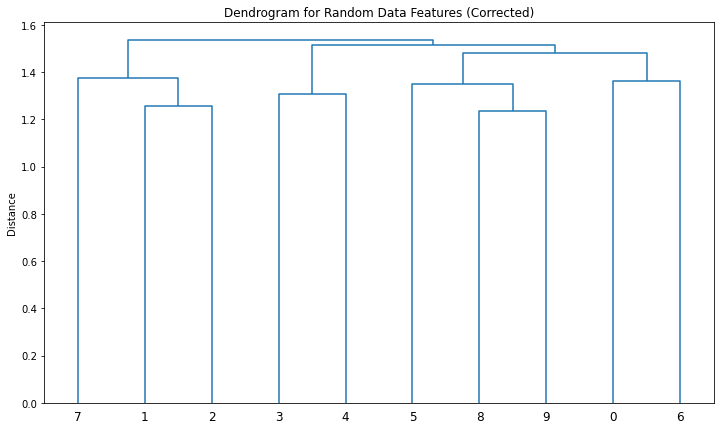

In [549]:
# Regenerate the random data and compute the matrices 重新生成随机数据并计算矩阵
np.random.seed(42)
X = np.random.rand(100, 10)
corr_matrix = np.corrcoef(X, rowvar=False)
dist_matrix = np.sqrt(2.0 * (1.0 - corr_matrix))
np.fill_diagonal(dist_matrix, 0)

# Perform hierarchical clustering using the corrected distance matrix  使用校正后的距离矩阵来计算层次聚类
linkage_matrix = hierarchy.linkage(distance.squareform(dist_matrix), method='complete')

# Plot the dendrogram using the corrected linkage matrix 使用校正后的矩阵来计算树状图
plt.figure(figsize=(12, 7))
dendrogram = hierarchy.dendrogram(linkage_matrix)
plt.title("Dendrogram for Random Data Features (Corrected)")
plt.ylabel("Distance")
plt.show()


In [555]:
# Load the dataset from the specified path 从制定路径加载数据集
code_features_df = pd.read_csv("E:/TERM2/Dissertation/Python/AIforCoding1.0/sampled_features.csv")

# Corrected column names for subsetting 更正了子集化的列名称
corrected_features_subset = [
    "file_name",
    "num_for_loops",
    "num_while_loops",
    "num_functions",
    "num_imports",
    "num_lines",
    "complexity"
]

# Subset the dataset to retain the selected features 对数据集进行子集化以保留特征
subsetted_df_corrected = code_features_df[corrected_features_subset]

# Display the first few rows of the subsetted dataset 显示子集前几行
print(subsetted_df_corrected.head())

# Save the subsetted DataFrame to the specified path 将子集化后的数据框保存到制定路径
subsetted_df_path = "E:/TERM2/Dissertation/Python/AIforCoding1.0/subsetted_code_features.CSV"
subsetted_df_corrected.to_csv(subsetted_df_path, index=False)


       file_name  num_for_loops  num_while_loops  num_functions  num_imports  \
0  s332061734.py            0.0              0.0            0.0          0.0   
1  s719640701.py            0.0              0.0            0.0          0.0   
2  s085202659.py            0.0              0.0            0.0          0.0   
3  s741896865.py            0.0              0.0            0.0          0.0   
4  s377784778.py            0.0              0.0            0.0          0.0   

   num_lines complexity  
0        8.0     Medium  
1        2.0        Low  
2        7.0     Medium  
3       10.0     Medium  
4       18.0       High  


In [556]:
# Reload the subsetted dataset 重新加载子集
subsetted_code_features_new_df = pd.read_csv("E:/TERM2/Dissertation/Python/AIforCoding1.0/subsetted_code_features.CSV")

# Confirming the dataset has been reloaded 确认数据集被重新加载
subsetted_code_features_new_df.head()
print(subsetted_code_features_new_df.head())


#Model Building建模
#Random Forests and Gradient Boosted Trees    随机森林  和 梯度提升树
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score

# Features and target variable 提取的特征和目标变量“复杂度”
X = subsetted_code_features_new_df[["num_for_loops", "num_while_loops", "num_functions", "num_imports", "num_lines"]]
y = subsetted_code_features_new_df["complexity"]

# Splitting the dataset into training (80%) and test (20%) sets 把数据集分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Training a Random Forest classifier 训练随机森林分类器
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

# Training a Gradient Boosted Trees classifier 训练梯度提升树分类器
gbt_classifier = GradientBoostingClassifier(random_state=42)
gbt_classifier.fit(X_train, y_train)

# Predictions 预测
rf_predictions = rf_classifier.predict(X_test)
gbt_predictions = gbt_classifier.predict(X_test)

# Evaluation  评估
rf_accuracy = accuracy_score(y_test, rf_predictions)
gbt_accuracy = accuracy_score(y_test, gbt_predictions)

rf_accuracy, gbt_accuracy


       file_name  num_for_loops  num_while_loops  num_functions  num_imports  \
0  s332061734.py            0.0              0.0            0.0          0.0   
1  s719640701.py            0.0              0.0            0.0          0.0   
2  s085202659.py            0.0              0.0            0.0          0.0   
3  s741896865.py            0.0              0.0            0.0          0.0   
4  s377784778.py            0.0              0.0            0.0          0.0   

   num_lines complexity  
0        8.0     Medium  
1        2.0        Low  
2        7.0     Medium  
3       10.0     Medium  
4       18.0       High  


(1.0, 1.0)

In [557]:
#交叉检验Cross-validation
# Number of folds 文件数量为5？？？？
k_folds = 5

# Cross-validation for Random Forest 随机森林的交叉检验
rf_cv_scores = cross_val_score(rf_classifier, X, y, cv=k_folds, scoring='accuracy')

# Cross-validation for Gradient Boosted Trees 梯度提升树的交叉检验
gbt_cv_scores = cross_val_score(gbt_classifier, X, y, cv=k_folds, scoring='accuracy')

# Average accuracies from cross-validation 交叉检验的平均准确率
rf_cv_avg_accuracy = np.mean(rf_cv_scores)
gbt_cv_avg_accuracy = np.mean(gbt_cv_scores)

rf_cv_avg_accuracy, gbt_cv_avg_accuracy


(1.0, 1.0)

Random Forest Classification Report:
              precision    recall  f1-score   support

        High       1.00      1.00      1.00        11
         Low       1.00      1.00      1.00        10
      Medium       1.00      1.00      1.00        79

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



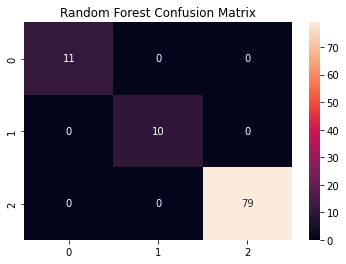

In [558]:
# Generate classification report for Random Forest随机森林分类报告
rf_report = classification_report(y_test, rf_predictions)
print("Random Forest Classification Report:")
print(rf_report)


# Generate confusion matrix for Random Forest随机森林混淆矩阵
rf_cm = confusion_matrix(y_test, rf_predictions)
sns.heatmap(rf_cm, annot=True, fmt='g')
plt.title('Random Forest Confusion Matrix')
plt.show()


Gradient Boosted Trees Classification Report:
              precision    recall  f1-score   support

        High       1.00      1.00      1.00        11
         Low       1.00      1.00      1.00        10
      Medium       1.00      1.00      1.00        79

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



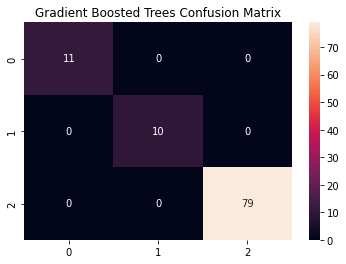

In [559]:
# Generate classification report for Gradient Boosted Trees梯度提升树的分类报告
gbt_report = classification_report(y_test, gbt_predictions)
print("Gradient Boosted Trees Classification Report:")
print(gbt_report)

# Generate confusion matrix for Gradient Boosted Trees 梯度提升树的混淆矩阵
gbt_cm = confusion_matrix(y_test, gbt_predictions)
sns.heatmap(gbt_cm, annot=True, fmt='g')
plt.title('Gradient Boosted Trees Confusion Matrix')
plt.show()

